In [1]:
import pandas as pd

In [2]:
df =pd.read_csv('1_dna_gyrase_bioactivity_data_curated.csv')
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL187677,C[C@H]1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)...,5.0,active
1,CHEMBL363449,CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,10.0,active
2,CHEMBL8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,5.0,active
3,CHEMBL192226,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C\F)c3c2F)CC1,72.2,active
4,CHEMBL371124,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C/F)c3c2F)CC1,664.0,active


In [3]:
df1= df.drop(columns='canonical_smiles')

In [4]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [5]:
df_clean_smiles = pd.concat([df1,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL187677,5.0,active,C[C@H]1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)...
1,CHEMBL363449,10.0,active,CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
2,CHEMBL8,5.0,active,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O
3,CHEMBL192226,72.2,active,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C\F)c3c2F)CC1
4,CHEMBL371124,664.0,active,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C/F)c3c2F)CC1
...,...,...,...,...
541,CHEMBL5431772,100000.0,active,COc1ccc2nccc(OC[C@H]3CC[C@H](NC(=O)c4cc(F)c(Br...
542,CHEMBL5429864,100000.0,active,COc1ccc2nccc(OC[C@H]3CC[C@H](NC(=O)c4ccc(I)c(F...
543,CHEMBL5394250,445.0,active,COc1ccc2nccc(OC[C@@H]3CC[C@@H](NC(=O)c4cc(F)c(...
544,CHEMBL5406927,185.0,active,COc1ccc2nccc(OC[C@@H]3CC[C@@H](NC(=O)c4cc(F)c(...


Calculate Descriptor

In [6]:
! pip install rdkit-pypi

ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


In [7]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

def lipinski(smiles, verbose=False):
    baseData = []  # List of lists
    i = 0  
    
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        if mol is not None:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            h_donors = Descriptors.NumHDonors(mol)
            h_acceptors = Descriptors.NumHAcceptors(mol)

            baseData.append([mw, logp, h_donors, h_acceptors])  # Append as a list

            if verbose:
                print(f"{i}: Processed {elem} -> MW: {mw}, LogP: {logp}, HDonors: {h_donors}, HAcceptors: {h_acceptors}")
        i += 1

    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)  # Ensure 2D structure
    
    return descriptors


In [10]:
lipinski_df = lipinski(df_clean_smiles.canonical_smiles.tolist())
lipinski_df

,MW,LogP,NumHDonors,NumHAcceptors
0,360.385,2.3071,2,5
1,360.385,2.3071,2,5
2,331.347,1.5833,2,5
3,367.327,2.1274,1,5
4,367.327,2.1274,1,5
...,...,...,...,...
541,506.347,5.0467,1,5
542,535.357,4.7497,1,5
543,463.868,3.9264,1,6
544,508.319,4.0355,1,6


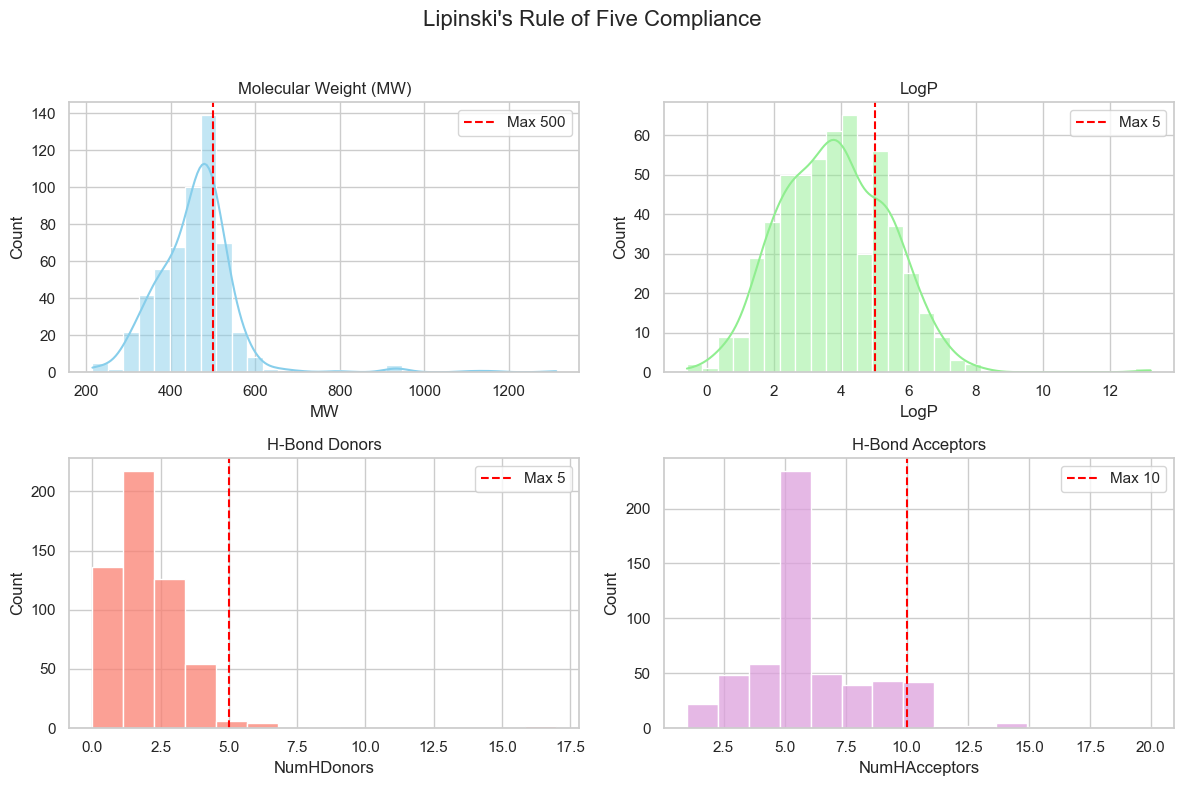

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Lipinski's Rule of Five Compliance", fontsize=16)

# Plot MW
sns.histplot(lipinski_df["MW"], bins=30, ax=axs[0, 0], kde=True, color='skyblue')
axs[0, 0].axvline(500, color='red', linestyle='--', label='Max 500')
axs[0, 0].set_title("Molecular Weight (MW)")
axs[0, 0].legend()

# Plot LogP
sns.histplot(lipinski_df["LogP"], bins=30, ax=axs[0, 1], kde=True, color='lightgreen')
axs[0, 1].axvline(5, color='red', linestyle='--', label='Max 5')
axs[0, 1].set_title("LogP")
axs[0, 1].legend()

# Plot NumHDonors
sns.histplot(lipinski_df["NumHDonors"], bins=15, ax=axs[1, 0], kde=False, color='salmon')
axs[1, 0].axvline(5, color='red', linestyle='--', label='Max 5')
axs[1, 0].set_title("H-Bond Donors")
axs[1, 0].legend()

# Plot NumHAcceptors
sns.histplot(lipinski_df["NumHAcceptors"], bins=15, ax=axs[1, 1], kde=False, color='plum')
axs[1, 1].axvline(10, color='red', linestyle='--', label='Max 10')
axs[1, 1].set_title("H-Bond Acceptors")
axs[1, 1].legend()

# Layout adjustment
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [13]:
df_combined= pd.concat([df,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187677,C[C@H]1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)...,5.0,active,360.385,2.3071,2.0,5.0
1,CHEMBL363449,CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,10.0,active,360.385,2.3071,2.0,5.0
2,CHEMBL8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,5.0,active,331.347,1.5833,2.0,5.0
3,CHEMBL192226,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C\F)c3c2F)CC1,72.2,active,367.327,2.1274,1.0,5.0
4,CHEMBL371124,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C/F)c3c2F)CC1,664.0,active,367.327,2.1274,1.0,5.0
...,...,...,...,...,...,...,...,...
663,NaN,NaN,NaN,active,NaN,NaN,NaN,NaN
664,NaN,NaN,NaN,active,NaN,NaN,NaN,NaN
665,NaN,NaN,NaN,active,NaN,NaN,NaN,NaN
666,NaN,NaN,NaN,active,NaN,NaN,NaN,NaN


Convert IC50 tp pIC50

In [14]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value', 1)
        
    return x

In [15]:
df_combined.standard_value.describe()

count       546.000000
mean      31804.536731
std       93435.208836
min           0.001000
25%          44.750000
50%         900.000000
75%       10150.000000
max      800000.000000
Name: standard_value, dtype: float64

In [16]:
-np.log10( (10**-9)* 100000000 )

1.0

In [17]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [18]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value_norm', axis=1)

        
    return x

In [19]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187677,C[C@H]1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)...,5.0,active,360.385,2.3071,2.0,5.0
1,CHEMBL363449,CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,10.0,active,360.385,2.3071,2.0,5.0
2,CHEMBL8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,5.0,active,331.347,1.5833,2.0,5.0
3,CHEMBL192226,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C\F)c3c2F)CC1,72.2,active,367.327,2.1274,1.0,5.0
4,CHEMBL371124,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C/F)c3c2F)CC1,664.0,active,367.327,2.1274,1.0,5.0
...,...,...,...,...,...,...,...,...
663,NaN,NaN,NaN,active,NaN,NaN,NaN,NaN
664,NaN,NaN,NaN,active,NaN,NaN,NaN,NaN
665,NaN,NaN,NaN,active,NaN,NaN,NaN,NaN
666,NaN,NaN,NaN,active,NaN,NaN,NaN,NaN


In [20]:
df_norm['standard_value'] = df_norm['standard_value'].astype(float)

In [21]:
def pIC50(input):
    pIC50 = []
    
    for i in input['standard_value']:
        molar = i * (10**-9)  # Convert nanomolar to molar
        pIC50.append(-np.log10(molar))  # Calculate pIC50
    
    input['pIC50'] = pIC50  # Add new column
    x = input.drop('standard_value', axis=1)  # Corrected drop method

    return x

In [22]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187677,C[C@H]1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)...,active,360.385,2.3071,2.0,5.0,8.301030
1,CHEMBL363449,CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,active,360.385,2.3071,2.0,5.0,8.000000
2,CHEMBL8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,active,331.347,1.5833,2.0,5.0,8.301030
3,CHEMBL192226,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C\F)c3c2F)CC1,active,367.327,2.1274,1.0,5.0,7.141463
4,CHEMBL371124,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C/F)c3c2F)CC1,active,367.327,2.1274,1.0,5.0,6.177832
...,...,...,...,...,...,...,...,...
663,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN
664,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN
665,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN


In [23]:
df_final.pIC50.describe()

count    546.000000
mean       6.219600
std        1.671627
min        3.096910
25%        4.993550
50%        6.046429
75%        7.349386
max       12.000000
Name: pIC50, dtype: float64

In [24]:
df_final.to_csv('dna_gyrase_bioactivity_data_class_pIC50.csv')

Remove Intermediate Class


In [25]:
df2= df_final[df_final['class'] != 'intermediate']
df2

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187677,C[C@H]1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)...,active,360.385,2.3071,2.0,5.0,8.301030
1,CHEMBL363449,CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,active,360.385,2.3071,2.0,5.0,8.000000
2,CHEMBL8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,active,331.347,1.5833,2.0,5.0,8.301030
3,CHEMBL192226,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C\F)c3c2F)CC1,active,367.327,2.1274,1.0,5.0,7.141463
4,CHEMBL371124,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(/C=C/F)c3c2F)CC1,active,367.327,2.1274,1.0,5.0,6.177832
...,...,...,...,...,...,...,...,...
663,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN
664,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN
665,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN


In [26]:
df2['class'].value_counts()

class
active      284
inactive    138
Name: count, dtype: int64

Text(0, 0.5, 'Frequency')

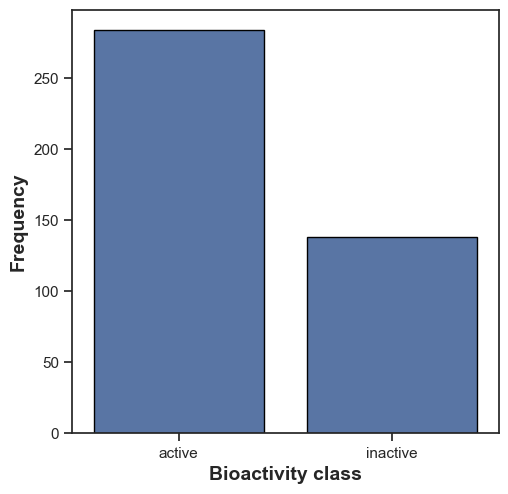

In [27]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df2, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

#plt.savefig('plot_bioactivity_class.pdf')